[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F8_autoencoder.ipynb)

# Autoencoder

In this example we are going to train an autoencoder on the MNIST data set.  
An autoencoder is transforming the input into some latent space and then back to the original space trying to match the original input. It can be used to reduce the dimensionality of the data and to generate new data.

We start with loading the data set just as before.

In [1]:
from torchvision.datasets import MNIST

In [2]:
data = MNIST("data", download=True)
X = data.data.reshape((len(data.data), 1, data.data.shape[-2], data.data.shape[-1])).numpy()/255.
y = data.targets.numpy()

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [5]:
import torch

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
X_train    = torch.Tensor(X_train).to(device)
X_test     = torch.Tensor(X_test).to(device)

The autoencoder consists of an encoder that transform the data into latent space and a decoder which brings it back into the original space.  
In this example the latent space has a dimensionality of $2$.

In [8]:
class AEnc(torch.nn.Module):
    
    def __init__(self, p_drop=0.03):
        
        super().__init__()
        
        self.act = torch.nn.SELU(inplace=False)
        self.drop = torch.nn.AlphaDropout(p=p_drop, inplace=False)
        
        self._encoder = torch.nn.Sequential(                                                  # (batch_size, 1, 28, 28) <- Input
            torch.nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2),                        # (batch_size, 8, 14, 14)
            self.act,                     
            self.drop,                     
            torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),                       # (batch_size, 16, 7, 7)
            self.act,
            self.drop,
            torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),                      # (batch_size, 16, 5, 5)
            torch.nn.Flatten(),                                                               # (batch_size, 16*5*5) = (batch_size, 400)
            self.act,
            self.drop,
            torch.nn.Linear(400, 64),                                                         # (batch_size, 64)
            self.act,                     
            self.drop,                     
            torch.nn.Linear(64, 2),                                                           # (batch_size, 2)          <- Output
        )                               
                                       
        self._decoder = torch.nn.Sequential(                                                  # (batch_size, 2)          <- input
            torch.nn.Linear(2, 64),                                                           # (batch_size, 64)
            self.act,
            self.drop,
            torch.nn.Linear(64, 400),                                                         # (batch_size, 400) = (batch_size, 16*5*5)
            self.act,
            self.drop,
            torch.nn.Unflatten(1, (16, 5, 5)),                                                # (batch_size, 16,  5,  5)
            torch.nn.ConvTranspose2d(16, 16, kernel_size=3, dilation=1, output_padding=0),    # (batch_size, 16, 7, 7)
            self.act,
            self.drop,
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, dilation=3, output_padding=1),     # (batch_size, 8, 14, 14)
            self.act,
            self.drop,
            torch.nn.ConvTranspose2d(8, 1, kernel_size=5, dilation=3, output_padding=2),      # (batch_size,  1, 28, 28) <- output
            torch.nn.Sigmoid()
            
        )
        
    def encode(self, x):
        return self._encoder(x)
    
    def decode(self, x):
        return self._decoder(x)
        
    def forward(self, x):
        y = self.encode(x)
        z = self.decode(y)
        return z

In [9]:
batch_size = 1_000
learning_rate = 1.e-2
weight_decay = 1.e-2
p_drop = 0.03
max_epochs = 5_000

In [10]:
aenc = AEnc(p_drop=p_drop).to(device)

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

The data loader only needs the data without the labels in this case, because the network is only trained to reproduce the data without a need of the labels.

In [12]:
dataloader = {}
_ = TensorDataset(X_train)
dataloader["train"] = DataLoader(_, batch_size=batch_size, shuffle=True)
_ = TensorDataset(X_test)
dataloader["test"] = DataLoader(_, batch_size=len(X_test), shuffle=False)

In [13]:
import copy
import numpy as np
from tqdm.auto import tqdm

In [14]:
def fit(net, dataloader, optimizer, scheduler, criterion, max_epochs):

    train_loss = []
    test_loss  = []
    best_loss = np.inf
    best_net = copy.deepcopy(net)

    pbar = tqdm(range(max_epochs), desc="Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs")
    for e in pbar:

        tr_loss = 0.
        te_loss = 0.

        datalen = len(dataloader["train"])
        
        net.train()
        for i, (data,) in enumerate(dataloader["train"]):
            optimizer.zero_grad()
            model = net(data)
            loss = criterion(model, data)
            loss.backward()
            optimizer.step()
            scheduler.step(e + i/datalen)
            tr_loss += loss.item()

        net.eval()
        for data, in dataloader["test"]:
            model = net(data)
            loss = criterion(model, data)
            te_loss += loss.item()

        train_loss.append(tr_loss/len(dataloader["train"]))
        test_loss.append(te_loss/len(dataloader["test"]))
        
        if test_loss[-1] < best_loss:
            best_net = copy.deepcopy(net)
            best_loss = test_loss[-1]
        
        pbar.set_description("Train Loss: {:1.3e} | Test Loss: {:1.3e} | Best Loss: {:1.3e} | Epochs".format(train_loss[-1], test_loss[-1], best_loss))
        
    loss = {
        "train": train_loss,
        "test": test_loss
    }
        
    return best_net, loss

Since this is not a classification problem we use the mean squared error as loss function.

In [15]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(aenc.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2)

In [16]:
aenc, loss = fit(aenc, dataloader, optimizer, scheduler, criterion, max_epochs)

Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

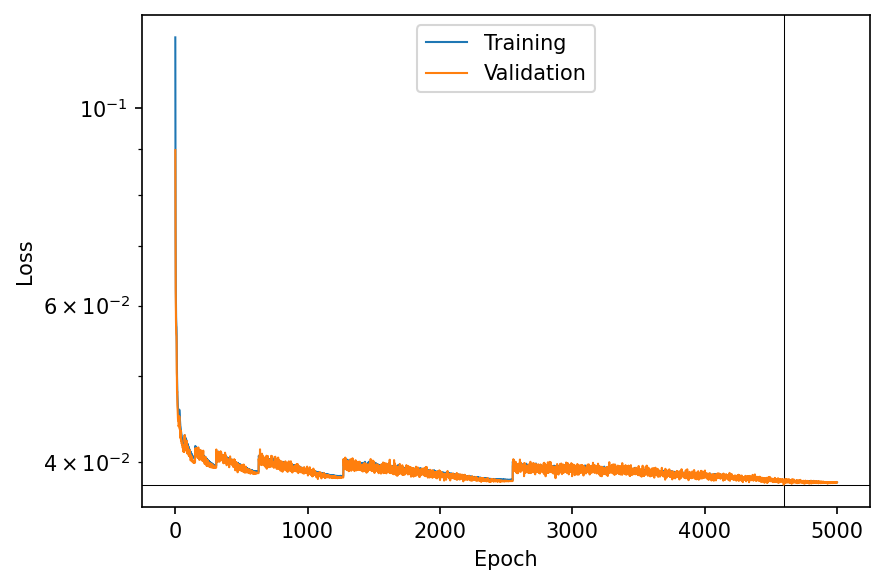

In [18]:
fig, ax = plt.subplots()
ax.axhline(np.min(loss["test"]), lw=0.5, c="black")
ax.axvline(np.argmin(loss["test"]), lw=0.5, c="black")
ax.plot(loss["train"], label="Training", lw=1)
ax.plot(loss["test"], label="Validation", lw=1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
fig.tight_layout()

We can now compare the original digits with their reconstructions. They look quite similar, but there are some wrong reconstructions we need to be aware of.

In [19]:
aenc.eval()
with torch.no_grad():
    Y_test = aenc(X_test[:9]).cpu()

In [20]:
def plot_tiles(X, y=None, N=5, random=True):
    Ntot = N**2
    d = int(np.sqrt(X[0].shape[0]))
    if random:
        rndi = np.random.choice(np.arange(X.shape[0]), Ntot, replace=False)
    else:
        rndi = np.arange(Ntot)
    fig, ax = plt.subplots(nrows=N, ncols=N)
    for i in range(Ntot):
        ix = i // N
        iy = i % N
        img = X[rndi[i], 0, ...]
        ax[ix, iy].imshow(img, cmap="Greys", vmax=X.max(), vmin=X.min())
        ax[ix, iy].axis("off")
        if y is not None:
            ax[ix, iy].set_title("{}".format(y[rndi[i]]), fontsize="small")
    fig.tight_layout()

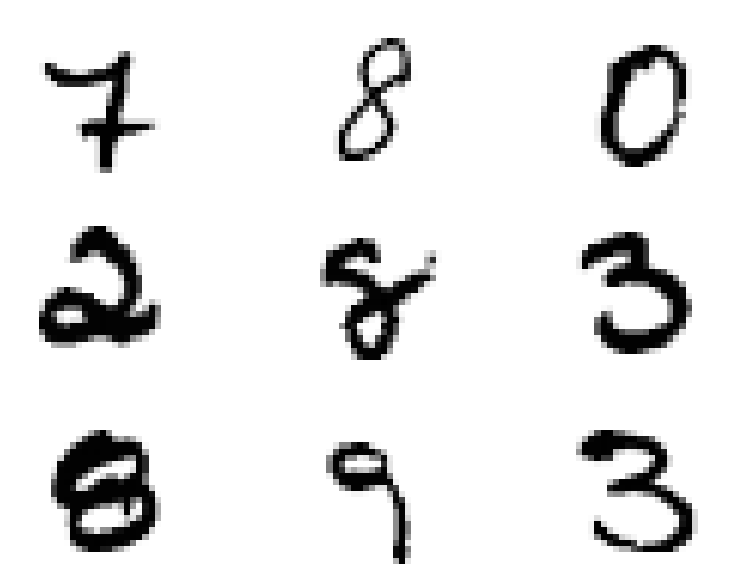

In [21]:
plot_tiles(X_test[:9].cpu(), random=False, N=3)

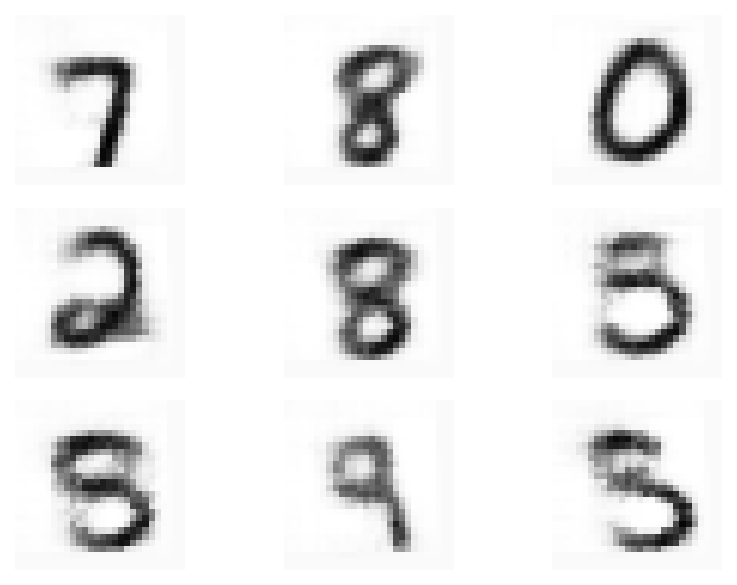

In [22]:
plot_tiles(Y_test.detach().numpy(), random=False, N=3)

Furthermore, we can plot the digits in latent space. They are nicely grouped and better separated than in the previous PCA example.  
There are, however, some overlaps when comparing for example $3$, $5$ and $8$.

In [23]:
aenc.eval()
with torch.no_grad():
    Z_test = aenc.encode(X_test).cpu()

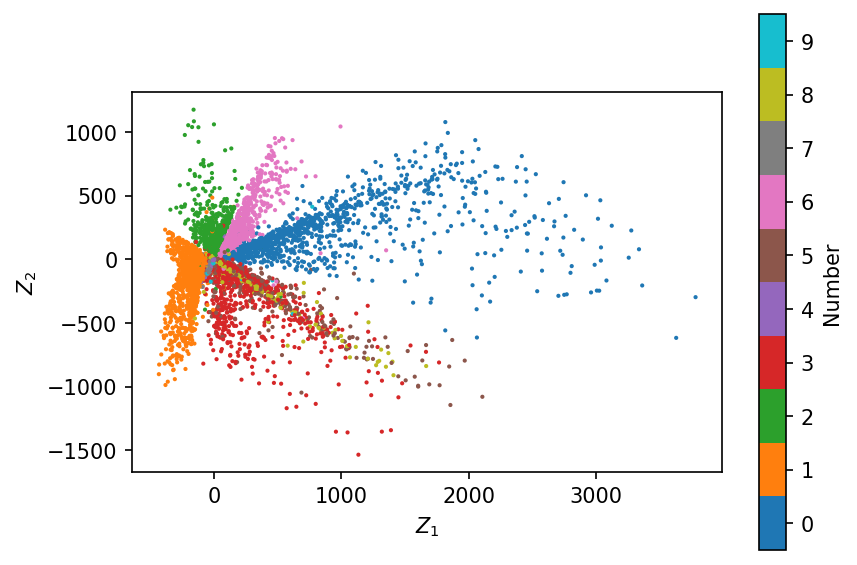

In [24]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test, cmap="tab10", vmin=-0.5, vmax=9.5, s=1)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(np.arange(10))
cbar.set_label("Number")
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
lim = np.abs(Z_test).max()
fig.tight_layout()

We can now generate digits by picking values from the latent space. In this case we are generating a grid from $-50$ to $50$ in both dimensions.  
This demonstrates how the digits morph into each other and especially highlights the confusion between certain digits.

In [25]:
grid = np.mgrid[-50:50:20*1j, -50:50:20*1j]
Y = np.swapaxes(grid, 0, -1).reshape(-1, 2)

In [26]:
Y = torch.tensor(Y).to(device).float()

In [27]:
with torch.no_grad():
    aenc.eval()
    Z = aenc.decode(Y)

In [28]:
def plot_tiles(X, y=None, N=5, random=True):
    Ntot = N**2
    d = int(np.sqrt(X[0].shape[0]))
    if random:
        rndi = np.random.choice(np.arange(X.shape[0]), Ntot, replace=False)
    else:
        rndi = np.arange(Ntot)
    fig, ax = plt.subplots(nrows=N, ncols=N, figsize=(N, N))
    for i in range(Ntot):
        ix = i // N
        iy = i % N
        img = X[rndi[i], 0, ...]
        ax[ix, iy].imshow(img, cmap="Greys", vmax=X.max(), vmin=X.min())
        ax[ix, iy].axis("off")
        if y is not None:
            ax[ix, iy].set_title("{}".format(y[rndi[i]]), fontsize="small")
    fig.tight_layout()

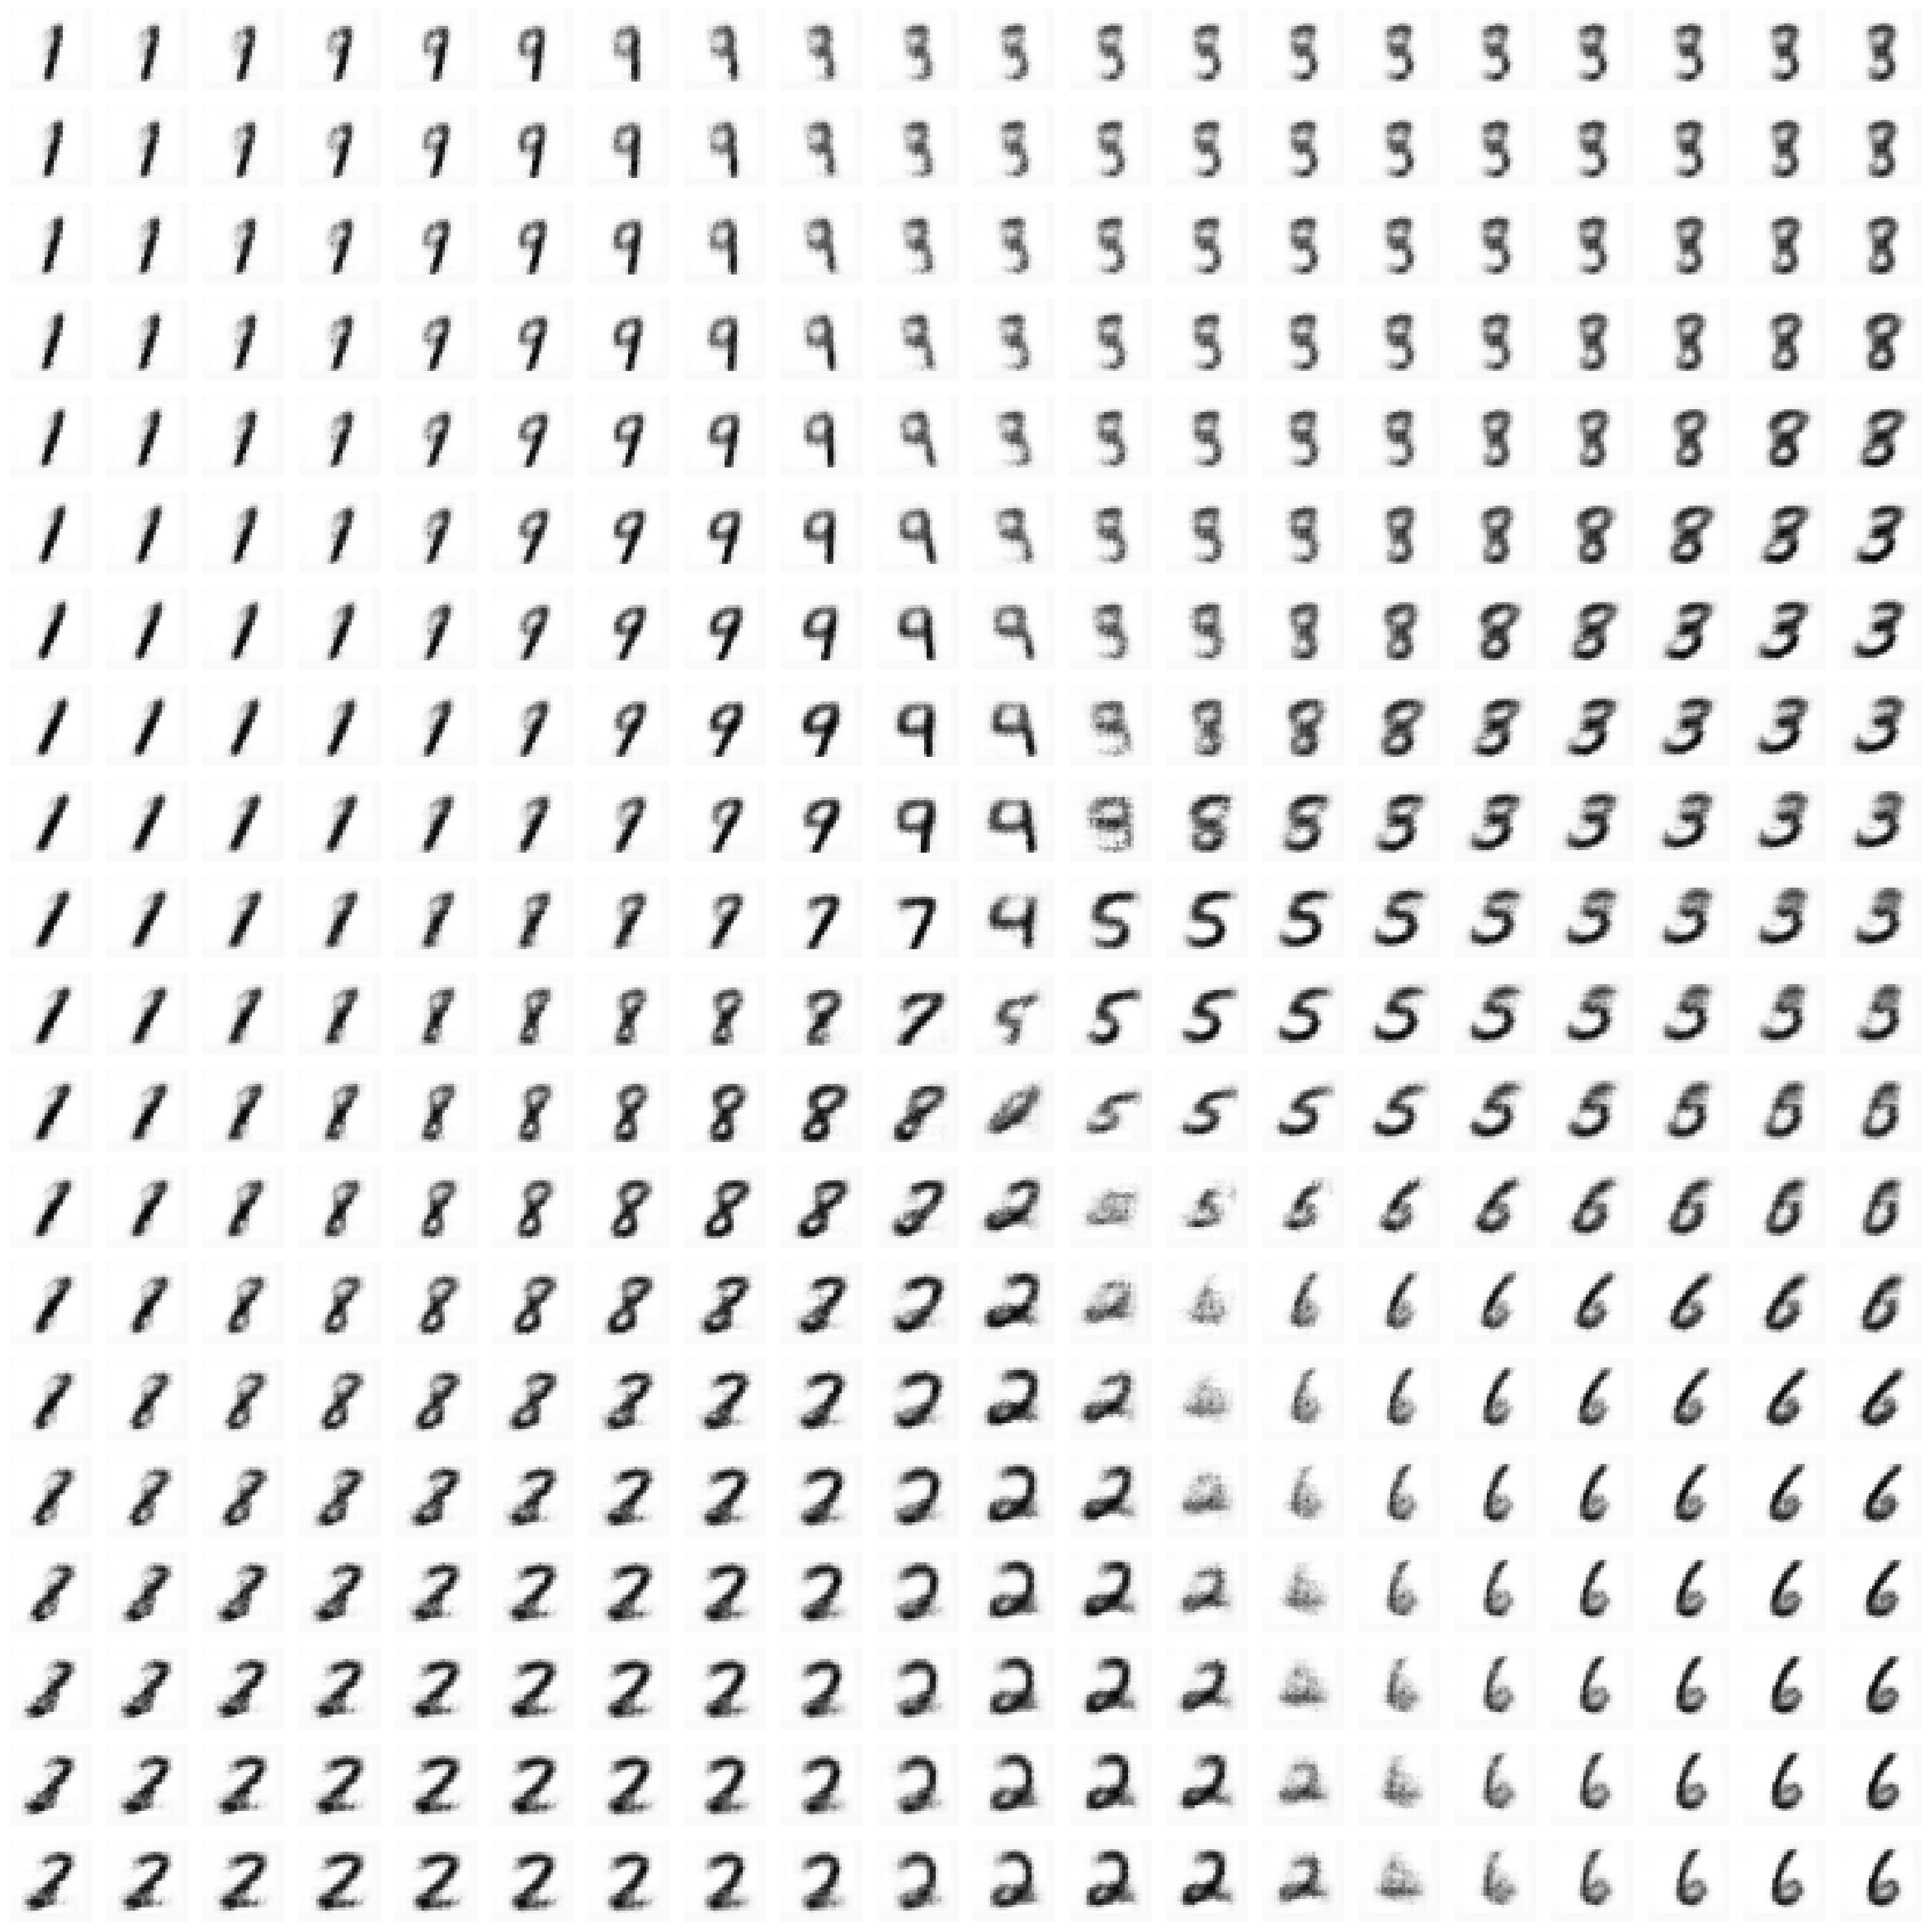

In [29]:
plot_tiles(Z.detach().cpu(), random=False, N=20)